<a href="https://colab.research.google.com/github/danialkhan02/MLApparelPredictor/blob/main/baseline_model_Apparel_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   Data Loading and Splitting



In [1]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
from tabulate import tabulate
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
import torchvision
from torchvision import datasets, transforms

torch.manual_seed(1) # set the random seed

In [3]:
# define the training, validation, testing directories
data_dir = "/content/gdrive/My Drive/images/MyersSet/"
training_data_dir = os.path.join(data_dir, "small_dataset_training")
validation_data_dir = os.path.join(data_dir, "small_dataset_validation")
testing_data_dir = os.path.join(data_dir, "small_dataset_testing")

classes = ["mens+tshirt",
"mens+shorts",
"mens+suit+jacket",
"dress",
"high+heels",
"sunglasses",
"watches",
"socks"
]

In [4]:
# Load and Transform using ImageFolder

# 244 x 244 pixels for the images, each image needs to be resized to be used later in the network
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor()])

# generic data loader for taking in the datasets and using it for the network
training_data_set = torchvision.datasets.ImageFolder(root=training_data_dir, transform=data_transform)
validation_data_set = torchvision.datasets.ImageFolder(root=validation_data_dir, transform=data_transform)
testing_data_set = torchvision.datasets.ImageFolder(root=testing_data_dir, transform=data_transform)


In [5]:
# Check out the number of data samples for training, validation, testing data
num_training_data = len(training_data_set)
num_val_data = len(validation_data_set)
num_testing_data = len(testing_data_set)

data = [["Training", num_training_data],
        ["Validation", num_val_data],
        ["Testing", num_testing_data],
        ["Total", (num_training_data + num_val_data + num_testing_data)]]

col_names = ["Type of Data", "Number of Data Samples"]

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))


╒════════════════╤══════════════════════════╕
│ Type of Data   │   Number of Data Samples │
╞════════════════╪══════════════════════════╡
│ Training       │                      168 │
├────────────────┼──────────────────────────┤
│ Validation     │                       80 │
├────────────────┼──────────────────────────┤
│ Testing        │                      135 │
├────────────────┼──────────────────────────┤
│ Total          │                      383 │
╘════════════════╧══════════════════════════╛


In [6]:
# define dataloader parameters
batch_size  = 55
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(training_data_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data_set, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

Baseline Convolutional Network

In [7]:
#Convolutional Neural Network Architecture
class CNN_ML_Apparel(nn.Module):
    def __init__(self):
        super(CNN_ML_Apparel, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size, string = 1, padding = 0
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(53*53*10, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 53*53*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')


Convolutional Neural Network Architecture Done


**Training the Data**

In [8]:
def get_accuracy(model, train=False, batch_size=27):
    if train:
        data = training_data_set
    else:
        data = validation_data_set

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [9]:
def train(model, data, batch_size=25, num_epochs=150, learn_rate=0.001, momentum=0.9):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    # Load in the data from fed into function
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)

    iters, losses, train_acc, val_acc = [], [], [], []

    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss

            train_acc.append(get_accuracy(model, train=True, batch_size=batch_size)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False, batch_size=batch_size))  # compute validation accuracy
            n += 1
        print(("Iteration (Epoch):", epoch, "Train accuracy:"), train_acc[-1])

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

**Overfit to the small myers dataset**

CNN
CUDA is available!  Training on GPU ...
CNN_ML_Apparel(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
('Iteration (Epoch):', 0, 'Train accuracy:') 0.125
('Iteration (Epoch):', 1, 'Train accuracy:') 0.125
('Iteration (Epoch):', 2, 'Train accuracy:') 0.30357142857142855
('Iteration (Epoch):', 3, 'Train accuracy:') 0.2619047619047619
('Iteration (Epoch):', 4, 'Train accuracy:') 0.36904761904761907
('Iteration (Epoch):', 5, 'Train accuracy:') 0.44047619047619047
('Iteration (Epoch):', 6, 'Train accuracy:') 0.3392857142857143
('Iteration (Epoch):', 7, 'Train accuracy:') 0.44642857142857145
('Iteration (Epoch):', 8, 'Train accuracy:') 0.39285714285714285
('Iteration (Epoch):', 9, 'Train accuracy:') 0.398809523

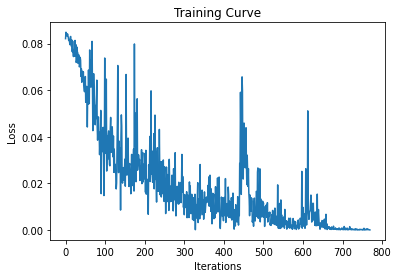

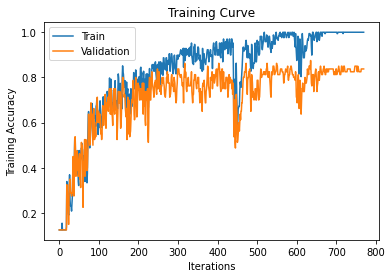

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8375


In [12]:
print("CNN")
model = CNN_ML_Apparel()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
print(model)


train(model, training_data_set,  num_epochs=110, batch_size=27, learn_rate=0.001, momentum=0.9)

Test the baseline model accuracy.

In [13]:
def get_test_accuracy(model, batch_size):
    data = testing_data_set
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        
        
        #############################################
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        
        output = model(imgs)
        
        # Select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [14]:
test_acc = get_test_accuracy(model, batch_size=27)
print("The test accuracy is", test_acc*100, "%.")

The test accuracy is 80.74074074074075 %.
